In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [55]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0          display            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [56]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [61]:
start_dt = '2021-07-28'
end_dt = '2021-08-29'
change_dt = '2021-08-18'
bundle = 'jp.gocro.smartnews.android'
BL_filename = 'SmartNewsInc_SmartNews_BL_20210830.txt'

we weren't blacklisting users who already had apps. now we are blacklisting same-app preloads. 

Scale drop on SmartNews, Newsbreak, Pandora, Tripledot - experience 1,2,3

Newsbreak - exp 2 - saw increase in past week (except for VZW, which dropped)

Expected increase on installs attributed to preloads.


start with smartnews:

- Did users that we stopped bidding on continue opening on Preload?

- Did percentage of organics by DT change?

- Before blacklist, how long between preload time and ST install time, preload time and preload install time.

# Did % of organics change?

In [5]:
df_organics = bigquery_client.query(f"""
select
    date(t_created) date
    , 16*count(case when is_attributed = TRUE then 1 else NULL end) attr_installs
    , 16*count(case when is_attributed = FALSE then 1 else NULL end) unattr_installs
    , 16*count(case when isorganic = TRUE then 1 else NULL end) organic_installs
    , 16*count(*) as total_installs
from external_data.ext_data 
where 
    bundle = '{bundle}'
    and date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}'
    and type = 'install'
    and right(ifa,1) = '0'
group by 1
""").to_dataframe()
df_organics['attr_rate'] = 100*df_organics.attr_installs/df_organics.total_installs
df_organics['unattr_rate'] = 100*df_organics.unattr_installs/df_organics.total_installs
df_organics['organic_rate'] = 100*df_organics.organic_installs/df_organics.total_installs
df_organics.set_index('date', inplace = True)

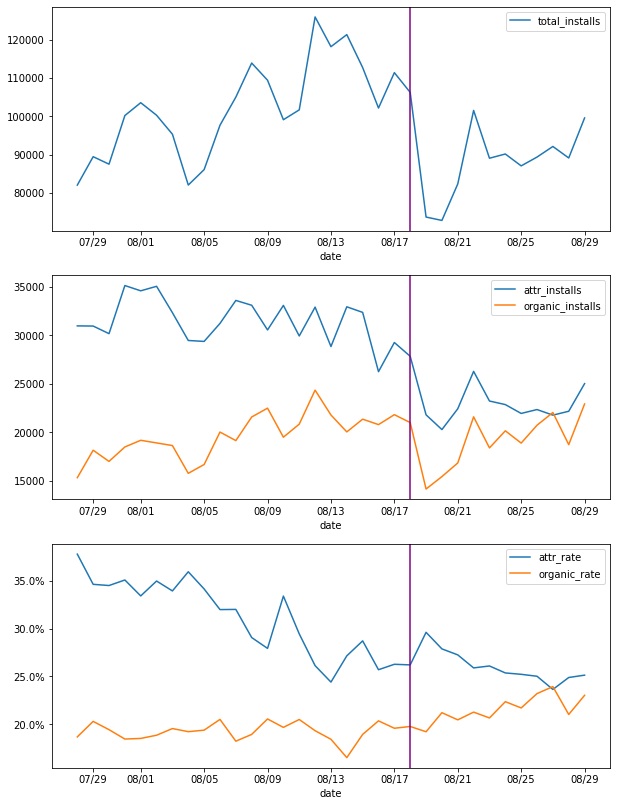

In [297]:
fig, ax = plt.subplots(3,1,figsize = (10,14))
df_organics.loc[:,['total_installs']].plot(ax = ax[0])
df_organics.loc[:,['attr_installs','organic_installs']].plot(ax = ax[1])
df_organics.loc[:,['attr_rate','organic_rate']].plot(ax = ax[2])
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].axvline(x=change_dt, color = 'purple')
ax[1].axvline(x=change_dt, color = 'purple')
ax[2].axvline(x=change_dt, color = 'purple')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

Looks like attributed rate dropped between 8/4 and 8/12. The preload BL was added on 8/18.

# Adding in preloads and BQ installs

In [302]:
query_preload = """
select 
    ctp.tracking_time as preload_ts
    , cti.tracking_time as install_ts
    , cti.tracking_time - ctp.tracking_time as preload_to_install
    , ctp.placement_id
    , ctp.advertising_id
from rawdata.campaign_tracking_active_preload ctp 
left join rawdata.campaign_tracking_active_install cti 
    on ctp.referrer = cti.referrer 
    and cti.tracking_time >= ctp.tracking_time
where ctp.android_package_name = '{bundle}'
and date(ctp.tracking_time) >= '{start_dt}'-30
and date(ctp.tracking_time) <= '{end_dt}'
and right(ctp.advertising_id,1) = '0'
and ctp.sti_type = 'Not Single Tap'
group by 1,2,3,4,5
"""
cur_atlas.execute(query_preload.format(start_dt = start_dt, end_dt = end_dt, bundle = bundle))
df_preload = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
df_preload.sort_values(['advertising_id','preload_ts','install_ts'], inplace = True)
df_preload.drop_duplicates(['advertising_id'], keep = 'last', inplace = True)

In [303]:
df_preload['advertising_id'].to_csv(f'files/{bundle}_preloads.csv', index = False, header = False)
!ruby ~/Documents/appreciate/ifas_to_tids.rb files/{bundle}_preloads.csv files/{bundle}_preloads_tids.csv
preload_list_tids = pd.read_csv(f'files/{bundle}_preloads_tids.csv', names = ['tid'])
preload_list_tids = preload_list_tids.join(pd.read_csv(f'files/{bundle}_preloads.csv', names = ['advertising_id']))
df_preload = pd.merge(df_preload, preload_list_tids, on = 'advertising_id')

In [59]:
tid_list = df_preload.tid.unique().tolist()
tid_list

['7c96f33507c025310ad3d3c08a2443da',
 'ab798271f0de6f639eb06086b843862c',
 '1dee1829aaa273e7252445ddb39f3bf5',
 'ba12bef6710f87a1e29257adf1330f57',
 'd467b052d4c733af5473e682c4326ae3',
 '747a7902b64068f3452ab58af4ca47d1',
 'a75e43e4453498ab58c8d9ecf3a1dcdc',
 '9f8876617ff8e6c2fc46914263958bc3',
 'a72f3f11607b07e8d7983c64037c0dd2',
 '6f671f8275e19decf81cdb6d891904dd',
 'f84d206e59fbacaae9e20e4e1601c414',
 '7fc4c4e3b63d3d2ab2d0fceb7f29b52c',
 'd2081ebc0bf33302dcd8e64c777846ed',
 'a5e319fce8ef335cfbd25fa0b46d2f63',
 '050584d1392feba86699857655cc9b1e',
 'fc79116031ac11053c30468983c630d1',
 'fd5b365934d7e3abfe8cc9ccdf81113a',
 '7b8c5c62eb000a40a033a8066542e83b',
 'ddd78dec954bde3b065ff46b40f6cabe',
 'e57717379fcb46d9c85510c75024e0f6',
 'bb848f71628376127ebaf5a1cad54114',
 '6dac86e6db96964575b8364ac2b252f3',
 '03a1b8b3ec88d5d0300178b16b79e362',
 'b7533e12157ed2e8b7c9d043109351ce',
 '25e425539948a50ab1486a3118caeed0',
 'cef946468585b34bc0a4b25c32db6697',
 'b5097118165685e7694f8ddf60ccd764',
 

In [10]:
bq_query = """
select
    r.etimestamp
    , extract(date from r.etimestamp) as edate
    , r.date 
    , r.timestamp
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id
    , r.tid 
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(case when event_type = 'install' then revenue else 0 end) as spend
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid  
join metadata.apps p
    on r.sponsored_app_id = p.app_id 
    and p.bundle = '{bundle}'
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and r.ssb_buyer_id = 3549
    and tid in {sublist}
group by 1,2,3,4,5,6,7,8
"""

In [11]:
bq_result_list = []

In [12]:
for i in range(np.ceil(len(tid_list)/1000).astype(int)):
    print(f'running query {i+1} of {np.ceil(len(tid_list)/1000)}')
    sublist = tuple(tid_list[i*1000: np.minimum((i+1)*1000-1, len(tid_list))])
    df_sub_bq = bigquery_client.query(bq_query.format(start_dt = start_dt, end_dt = end_dt, sublist = sublist, bundle = bundle)).to_dataframe()
    bq_result_list.append(df_sub_bq)

bq_result = pd.concat(bq_result_list)
bq_result['experience_type'] = bq_result.apply(lambda x:classify_campaigns(x), axis = 1)

running query 1 of 555.0
running query 2 of 555.0
running query 3 of 555.0
running query 4 of 555.0
running query 5 of 555.0
running query 6 of 555.0
running query 7 of 555.0
running query 8 of 555.0
running query 9 of 555.0
running query 10 of 555.0
running query 11 of 555.0
running query 12 of 555.0
running query 13 of 555.0
running query 14 of 555.0
running query 15 of 555.0
running query 16 of 555.0
running query 17 of 555.0
running query 18 of 555.0
running query 19 of 555.0
running query 20 of 555.0
running query 21 of 555.0
running query 22 of 555.0
running query 23 of 555.0
running query 24 of 555.0
running query 25 of 555.0
running query 26 of 555.0
running query 27 of 555.0
running query 28 of 555.0
running query 29 of 555.0
running query 30 of 555.0
running query 31 of 555.0
running query 32 of 555.0
running query 33 of 555.0
running query 34 of 555.0
running query 35 of 555.0
running query 36 of 555.0
running query 37 of 555.0
running query 38 of 555.0
running query 39 of 5

running query 309 of 555.0
running query 310 of 555.0
running query 311 of 555.0
running query 312 of 555.0
running query 313 of 555.0
running query 314 of 555.0
running query 315 of 555.0
running query 316 of 555.0
running query 317 of 555.0
running query 318 of 555.0
running query 319 of 555.0
running query 320 of 555.0
running query 321 of 555.0
running query 322 of 555.0
running query 323 of 555.0
running query 324 of 555.0
running query 325 of 555.0
running query 326 of 555.0
running query 327 of 555.0
running query 328 of 555.0
running query 329 of 555.0
running query 330 of 555.0
running query 331 of 555.0
running query 332 of 555.0
running query 333 of 555.0
running query 334 of 555.0
running query 335 of 555.0
running query 336 of 555.0
running query 337 of 555.0
running query 338 of 555.0
running query 339 of 555.0
running query 340 of 555.0
running query 341 of 555.0
running query 342 of 555.0
running query 343 of 555.0
running query 344 of 555.0
running query 345 of 555.0
r

In [13]:
bq_result = bq_result[bq_result.tid.isin(tid_list)]
bq_result['experience_type'] = bq_result.apply(lambda x:classify_campaigns(x), axis = 1)

# Did we see a drop on certain campaigns (retargeting preloads) at the time of blacklisting?

In [14]:
spend_by_campaign = bigquery_client.query(f"""
select
    c.name as campaign_name
    , r.ssb_buyer_id
    , r.ssb_campaign_uuid
    , r.date 
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(case when event_type = 'install' then revenue else 0 end) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost 
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid 
join metadata.apps sp 
    on r.sponsored_app_id = sp.app_id
    and sp.bundle = '{bundle}'
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
group by 1,2,3,4
""").to_dataframe()
spend_by_campaign['experience_type'] = spend_by_campaign.apply(lambda x:classify_campaigns(x), axis = 1)

In [319]:
spend_by_campaign.reset_index()[['campaign_name','experience_type','ssb_campaign_uuid']].drop_duplicates().sort_values('experience_type')

campaign_name  experience_type  \
4          SmartNews_Verizon_SingleTap_All_CPI_NA                1   
7         SmartNews_Tracfone_SingleTap_All_CPI_NA                1   
11         SmartNews_Cricket_SingleTap_All_CPI_NA                1   
41             SmartNews_ATT_SingleTap_All_CPI_NA                1   
43            SmartNews_USCC_SingleTap_All_CPI_NA                1   
1         Android-SmartNews Inc-SmartNews-US-VZ-2                2   
5       Android-SmartNews Inc-SmartNews-US-USCC-2                2   
14  Android-SmartNews Inc-SmartNews-US-Tracfone-2                2   
16       Android-SmartNews Inc-SmartNews-US-ATT-2                2   
17   Android-SmartNews Inc-SmartNews-US-Cricket-2                2   
0        Android-SmartNews Inc-SmartNews-US-ATT-3                3   
2    Android-SmartNews Inc-SmartNews-US-Cricket-3                3   
6   Android-SmartNews Inc-SmartNews-US-Tracfone-3                3   
44        Android-SmartNews Inc-SmartNews-US-VZ-3                3   
53      Android-SmartNews Inc-SmartNews-US-USCC-3                3   

                   ssb_campaign_uuid  
4   5fef83d15c5b811b424ed58aeb82d0a7  
7   d8be47c87ebd5047c552f92421103f1a  
11  eb6dbe92b98fe9a91b00eb06ae37070e  
41  33bff90d655b976e9399f1d0b0463d22  
43  608ffd6123bdbf7eef34f27889501862  
1   099a5d47e9bf3796c1b9ca5c5f4bc264  
5   0845c2b2f652fe4e4a959d7edd27de2a  
14  d018489d8075c72fa12c6bf0e7f54fbb  
16  460c77fda3ba6cdf651311f5eedb7187  
17  545149fc54f7c1283d6c0c90ab8ce7e2  
0   52e074885806d19e5393c010eca2617d  
2   b765a8c07a99a8bb51a18bbc50866329  
6   faed52a49eb4914b698a209027f1a00f  
44  30968a4138fff2fb0b0601173f9d39e2  
53  626100a0509365a389a45a8d8e696ac1

In [15]:
spend_by_campaign.set_index(['campaign_name','date'], inplace = True)
spend_by_campaign

ssb_buyer_id  \
campaign_name                                date                       
Android-SmartNews Inc-SmartNews-US-ATT-3     2021-07-31          3549   
Android-SmartNews Inc-SmartNews-US-VZ-2      2021-07-31          3549   
Android-SmartNews Inc-SmartNews-US-Cricket-3 2021-08-29          3549   
                                             2021-08-01          3549   
SmartNews_Verizon_SingleTap_All_CPI_NA       2021-08-03          3549   
...                                                               ...   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-10          3549   
Android-SmartNews Inc-SmartNews-US-USCC-2    2021-08-01          3549   
Android-SmartNews Inc-SmartNews-US-Cricket-2 2021-08-01          3549   
SmartNews_USCC_SingleTap_All_CPI_NA          2021-08-19          3549   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-21          3549   

                                                                        ssb_campaign_uuid  \
campaign_name                                date                                           
Android-SmartNews Inc-SmartNews-US-ATT-3     2021-07-31  52e074885806d19e5393c010eca2617d   
Android-SmartNews Inc-SmartNews-US-VZ-2      2021-07-31  099a5d47e9bf3796c1b9ca5c5f4bc264   
Android-SmartNews Inc-SmartNews-US-Cricket-3 2021-08-29  b765a8c07a99a8bb51a18bbc50866329   
                                             2021-08-01  b765a8c07a99a8bb51a18bbc50866329   
SmartNews_Verizon_SingleTap_All_CPI_NA       2021-08-03  5fef83d15c5b811b424ed58aeb82d0a7   
...                                                                                   ...   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-10  eb6dbe92b98fe9a91b00eb06ae37070e   
Android-SmartNews Inc-SmartNews-US-USCC-2    2021-08-01  0845c2b2f652fe4e4a959d7edd27de2a   
Android-SmartNews Inc-SmartNews-US-Cricket-2 2021-08-01  545149fc54f7c1283d6c0c90ab8ce7e2   
SmartNews_USCC_SingleTap_All_CPI_NA          2021-08-19  608ffd6123bdbf7eef34f27889501862   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-21  eb6dbe92b98fe9a91b00eb06ae37070e   

                                                         impressions  clicks  \
campaign_name                                date                              
Android-SmartNews Inc-SmartNews-US-ATT-3     2021-07-31       940861   22830   
Android-SmartNews Inc-SmartNews-US-VZ-2      2021-07-31       198423   10189   
Android-SmartNews Inc-SmartNews-US-Cricket-3 2021-08-29       328972    2199   
                                             2021-08-01       249621    7666   
SmartNews_Verizon_SingleTap_All_CPI_NA       2021-08-03       116617    3849   
...                                                              ...     ...   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-10        47360    1828   
Android-SmartNews Inc-SmartNews-US-USCC-2    2021-08-01        53789    3009   
Android-SmartNews Inc-SmartNews-US-Cricket-2 2021-08-01        87961    7599   
SmartNews_USCC_SingleTap_All_CPI_NA          2021-08-19        12863     552   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-21        47000    1646   

                                                         installs   spend  \
campaign_name                                date                           
Android-SmartNews Inc-SmartNews-US-ATT-3     2021-07-31       785  1334.5   
Android-SmartNews Inc-SmartNews-US-VZ-2      2021-07-31       963  1637.1   
Android-SmartNews Inc-SmartNews-US-Cricket-3 2021-08-29        84   142.8   
                                             2021-08-01       534   907.8   
SmartNews_Verizon_SingleTap_All_CPI_NA       2021-08-03      2395  4071.5   
...                                                           ...     ...   
SmartNews_Cricket_SingleTap_All_CPI_NA       2021-08-10       909  1545.3   
Android-SmartNews Inc-SmartNews-US-USCC-2    2021-08-01       550   935.0   
Android-SmartNews Inc-SmartNews-US-Cricket-2 2021-08-01       909  1540.3   
SmartNews

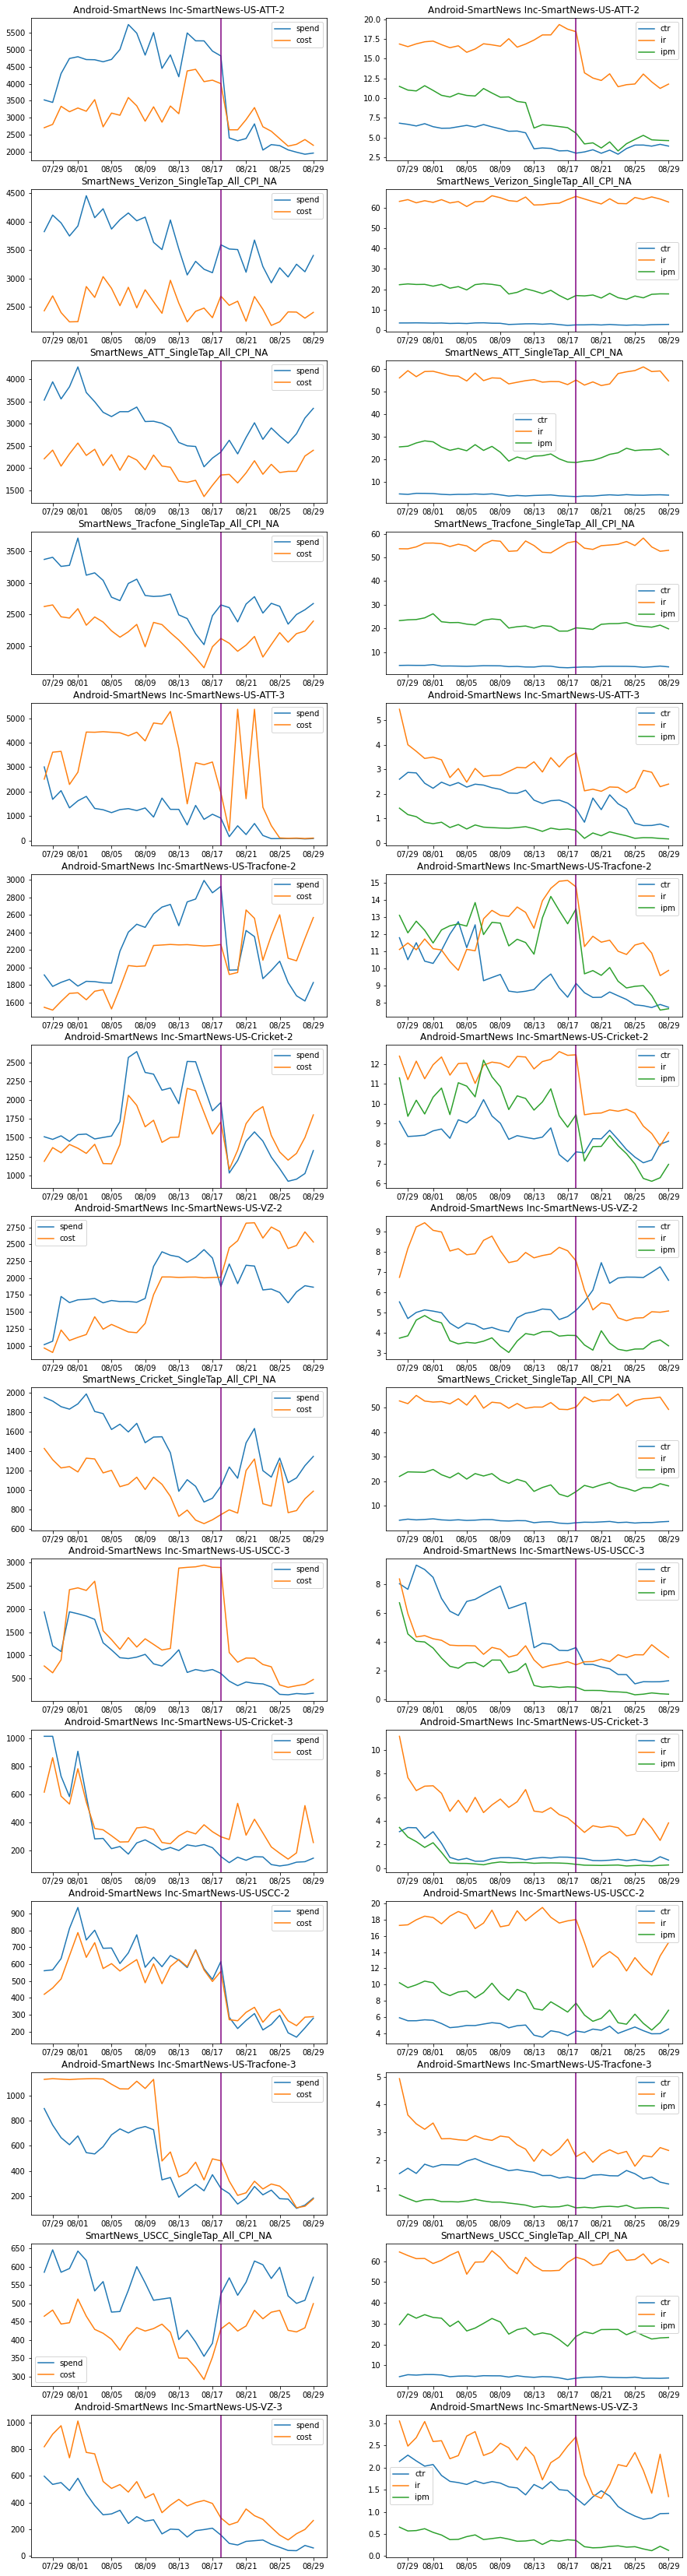

In [16]:
campaigns = spend_by_campaign.sort_values('spend', ascending = False).index.get_level_values(0).unique().tolist()
fig, ax = plt.subplots(len(campaigns),2, figsize = (15, 4*len(campaigns)))

for c in range(len(campaigns)):
    campaign = campaigns[c]
    sub_df = spend_by_campaign[spend_by_campaign.index.get_level_values(0) == campaign].droplevel(0).sort_index()
    sub_df['ctr'] = 100*sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = 100*sub_df['installs']/sub_df['clicks']
    sub_df['ipm'] = 1000*sub_df.installs/sub_df.impressions
    sub_df.index = pd.to_datetime(sub_df.index)
    
    ax[c,0].plot(sub_df[['spend','cost']])
    ax[c,0].set_title(campaign)
    ax[c,0].legend(['spend','cost'])
    ax[c,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[c,0].axvline(x = pd.to_datetime(change_dt), color = 'purple')
    ax[c,1].plot(sub_df[['ctr','ir','ipm']])
    ax[c,1].set_title(campaign)
    ax[c,1].legend(['ctr','ir','ipm'])
    ax[c,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[c,1].axvline(x = pd.to_datetime(change_dt), color = 'purple')

Looks like the drop is largest on experience 2, in terms of IR.

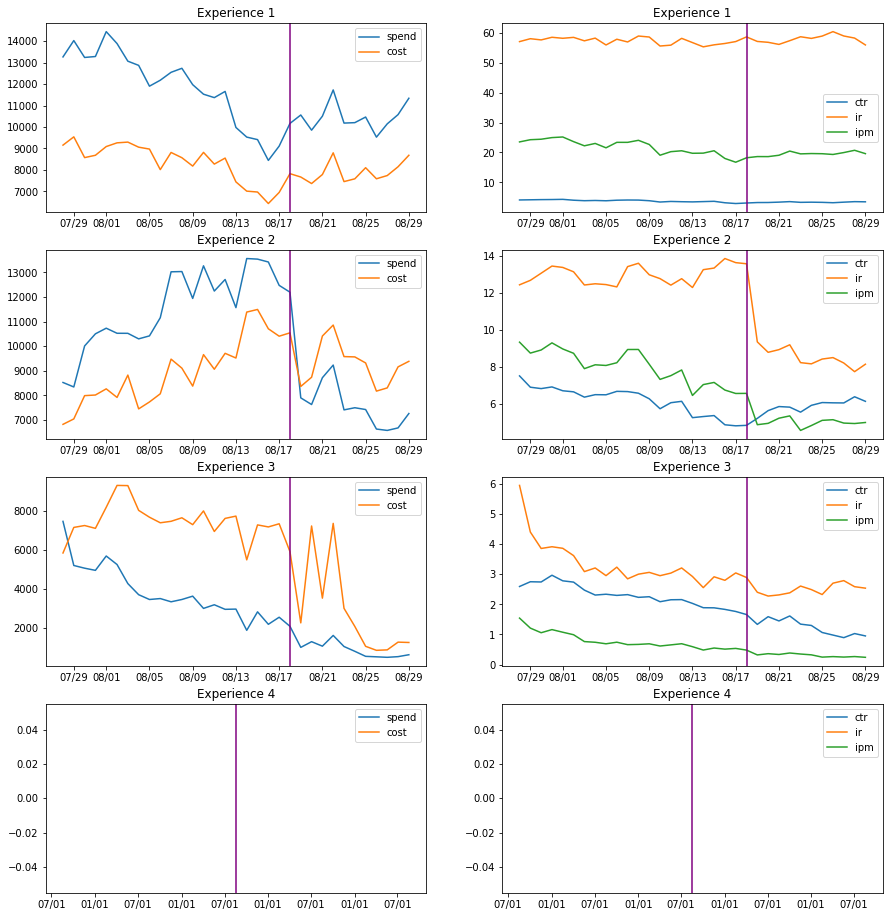

In [17]:
spend_by_experience = spend_by_campaign.groupby(['experience_type','date'])['impressions','clicks','installs','spend','cost'].sum()
fig, ax = plt.subplots(4,2, figsize = (15, 16))

for c in range(4):
    sub_df = spend_by_experience[spend_by_experience.index.get_level_values(0) == c+1].droplevel(0).sort_index()
    sub_df['ctr'] = 100*sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = 100*sub_df['installs']/sub_df['clicks']
    sub_df['ipm'] = 1000*sub_df.installs/sub_df.impressions
    sub_df.index = pd.to_datetime(sub_df.index)
    
    ax[c,0].plot(sub_df[['spend','cost']])
    ax[c,0].set_title(f'Experience {c+1}')
    ax[c,0].legend(['spend','cost'])
    ax[c,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[c,0].axvline(x = pd.to_datetime(change_dt), color = 'purple')
    ax[c,1].plot(sub_df[['ctr','ir','ipm']])
    ax[c,1].set_title(f'Experience {c+1}')
    ax[c,1].legend(['ctr','ir','ipm'])
    ax[c,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[c,1].axvline(x = pd.to_datetime(change_dt), color = 'purple')

# How often were we cannibalizing preloads?

In [355]:
exp1 = (bq_result.experience_type == 1)
exp2 = (bq_result.experience_type == 2)
first_imp_exp1 = bq_result[exp1 & (bq_result.impressions > 0)].pivot_table(values = 'etimestamp', index = 'tid', aggfunc = 'min')
first_install_exp1 = bq_result[exp1 & (bq_result.installs > 0)].pivot_table(values = 'etimestamp', index = 'tid', aggfunc = 'min')
first_imp_exp2 = bq_result[exp2 & (bq_result.impressions > 0)].pivot_table(values = 'etimestamp', index = 'tid', aggfunc = 'min')
first_install_exp2 = bq_result[exp2 & (bq_result.installs > 0)].pivot_table(values = 'etimestamp', index = 'tid', aggfunc = 'min')

exp1_bydevice = first_imp_exp1.join(first_install_exp1, how = 'left', lsuffix = '_imp')
exp1_bydevice.rename(columns = {'etimestamp_imp':'imp_ts_exp1','etimestamp':'DSP_install_ts_exp1'}, inplace = True)
exp2_bydevice = first_imp_exp2.join(first_install_exp2, how = 'left', lsuffix = '_imp')
exp2_bydevice.rename(columns = {'etimestamp_imp':'imp_ts_exp2','etimestamp':'DSP_install_ts_exp2'}, inplace = True)
exp1_bydevice['imp_ts_exp1'] = exp1_bydevice['imp_ts_exp1'].dt.tz_localize(None)
exp2_bydevice['imp_ts_exp2'] = exp2_bydevice['imp_ts_exp2'].dt.tz_localize(None)
exp1_bydevice['DSP_install_ts_exp1'] = exp1_bydevice['DSP_install_ts_exp1'].dt.tz_localize(None)
exp2_bydevice['DSP_install_ts_exp2'] = exp2_bydevice['DSP_install_ts_exp2'].dt.tz_localize(None)

joined = df_preload.set_index('tid').join(exp1_bydevice, how = 'left')
joined = joined.join(exp2_bydevice, how = 'left')
joined['preload_to_imp_exp1'] = joined.imp_ts_exp1 - joined.preload_ts
joined['preload_to_imp_exp2'] = joined.imp_ts_exp2 - joined.preload_ts
joined['preload_to_DSP_install_exp1'] = joined.DSP_install_ts_exp1 - joined.preload_ts
joined['preload_to_DSP_install_exp2'] = joined.DSP_install_ts_exp2 - joined.preload_ts
joined

preload_ts          install_ts  \
tid                                                                        
7c96f33507c025310ad3d3c08a2443da 2021-07-31 14:37:51 2021-08-10 11:03:20   
ab798271f0de6f639eb06086b843862c 2021-07-01 15:53:11                 NaT   
1dee1829aaa273e7252445ddb39f3bf5 2021-07-27 14:16:43                 NaT   
ba12bef6710f87a1e29257adf1330f57 2021-07-01 12:28:42                 NaT   
d467b052d4c733af5473e682c4326ae3 2021-07-16 21:02:18                 NaT   
...                                              ...                 ...   
2c8f8305b764344f786759a3859da400 2021-08-06 14:19:50                 NaT   
3232b8401e629b56e7473c3c4c43dbd8 2021-08-22 13:15:15                 NaT   
dcc57e16f2f7f89d6a0d9a828710bb95 2021-06-30 20:58:32                 NaT   
0793150e291609b8a9b53466e4b47ff3 2021-08-13 02:08:10                 NaT   
d6f86ab2a4cc627230d8240f48224da0 2021-08-09 16:12:30 2021-08-09 16:48:26   

                                 preload_to_install  placement_id  \
tid                                                                 
7c96f33507c025310ad3d3c08a2443da    9 days 20:25:29             1   
ab798271f0de6f639eb06086b843862c                NaT             1   
1dee1829aaa273e7252445ddb39f3bf5                NaT             1   
ba12bef6710f87a1e29257adf1330f57                NaT             1   
d467b052d4c733af5473e682c4326ae3                NaT             1   
...                                             ...           ...   
2c8f8305b764344f786759a3859da400                NaT             1   
3232b8401e629b56e7473c3c4c43dbd8                NaT             1   
dcc57e16f2f7f89d6a0d9a828710bb95                NaT             1   
0793150e291609b8a9b53466e4b47ff3                NaT             1   
d6f86ab2a4cc627230d8240f48224da0    0 days 00:35:56             1   

                                                        advertising_id  \
tid                                                                      
7c96f33507c025310ad3d3c08a2443da  00004651-ec94-41b9-b235-8db669597a50   
ab798271f0de6f639eb06086b843862c  000071ea-3864-47f7-b67e-19423bb5fbf0   
1dee1829aaa273e7252445ddb39f3bf5  00008c40-4446-4235-a65f-9f4e57543230   
ba12bef6710f87a1e29257adf1330f57  0000a79a-0caa-4730-a326-1c34b1343840   
d467b052d4c733af5473e682c4326ae3  0000f14a-994d-4842-898d-2be13405f3c0   
...                                                                ...   
2c8f8305b764344f786759a3859da400  fffefb15-1061-4616-be43-cf01b27cedd0   
3232b8401e629b56e7473c3c4c43dbd8  ffff3ab8-5d0a-4e71-a08d-dedb47bb55c0   
dcc57e16f2f7f89d6a0d9a828710bb95  ffff54d2-f8a4-4f31-83b7-37a877d35ea0   
0793150e291609b8a9b53466e4b47ff3  ffff7c77-877c-4372-ac6b-fcad926ff1e0   
d6f86ab2a4cc627230d8240f48224da0  ffffc484-c26e-4bb4-8dbb-16e7b5c16c00   

                                         imp_ts_exp1 DSP_install_ts_exp1  \
tid                                                                        
7c96f33507c025310ad3d3c08a2443da                 NaT                 NaT   
ab798271f0de6f639eb06086b843862c                 NaT                 NaT   
1dee1829aaa273e7252445ddb39f3bf5 2021-08-13 15:51:23                 NaT   
ba12bef6710f87a1e29257adf1330f57 2021-08-01 23:35:50                 NaT   
d467b052d4c733af5473e682c4326ae3                 NaT                 NaT   
...                                              ...                 ...   
2c8f8305b764344f786759a3859da400                 NaT                 NaT   
3232b8401e629b56e7473c3c4c43dbd8                 NaT                 NaT   
dcc57e16f2f7f89d6a0d9a828710bb95                 NaT                 NaT   
0793150e291609b8a9b53466e4b47ff3                 NaT                 NaT   
d6f86ab2a4cc627230d8240f48224da0                 NaT                 NaT   

                                         imp_ts_exp2 DSP_install_ts_exp2  \
tid                                                                        
7c96f33507c025310ad3d3c08a2443da                 Na

In [19]:
query_organic_installs = """
select
    tid
    , min(case when isorganic = TRUE then t_created else NULL end) as organic_install_ts
    , min(case when isorganic = FALSE then t_created else NULL end) as other_attr_install_ts
from external_data.ext_data 
where 
    bundle = '{bundle}'
    and date(t_created) >= '{start_dt}'-30
    and date(t_created) <= '{end_dt}'
    and type = 'install'
    and tid in {sublist}
    and is_attributed = FALSE
group by 1
"""
df_organic_install_list = []

for i in range(np.ceil(len(tid_list)/10000).astype(int)):
    print(f'running query {i+1} of {np.ceil(len(tid_list)/10000)}')
    sublist = tuple(tid_list[i*10000: np.minimum((i+1)*10000-1, len(tid_list))])
    df_sub_bq = bigquery_client.query(query_organic_installs.format(start_dt = start_dt, end_dt = end_dt, sublist = sublist, bundle = bundle)).to_dataframe()
    df_organic_install_list.append(df_sub_bq)

df_organic_installs = pd.concat(df_organic_install_list)

running query 1 of 56.0
running query 2 of 56.0
running query 3 of 56.0
running query 4 of 56.0
running query 5 of 56.0
running query 6 of 56.0
running query 7 of 56.0
running query 8 of 56.0
running query 9 of 56.0
running query 10 of 56.0
running query 11 of 56.0
running query 12 of 56.0
running query 13 of 56.0
running query 14 of 56.0
running query 15 of 56.0
running query 16 of 56.0
running query 17 of 56.0
running query 18 of 56.0
running query 19 of 56.0
running query 20 of 56.0
running query 21 of 56.0
running query 22 of 56.0
running query 23 of 56.0
running query 24 of 56.0
running query 25 of 56.0
running query 26 of 56.0
running query 27 of 56.0
running query 28 of 56.0
running query 29 of 56.0
running query 30 of 56.0
running query 31 of 56.0
running query 32 of 56.0
running query 33 of 56.0
running query 34 of 56.0
running query 35 of 56.0
running query 36 of 56.0
running query 37 of 56.0
running query 38 of 56.0
running query 39 of 56.0
running query 40 of 56.0
running q

In [69]:
df_organic_installs = df_organic_installs[df_organic_installs.tid.isin(tid_list)]

In [356]:
df_organic_installs['organic_install_ts'] = df_organic_installs['organic_install_ts'].dt.tz_localize(None)
df_organic_installs['other_attr_install_ts'] = df_organic_installs['other_attr_install_ts'].dt.tz_localize(None)
joined = joined.join(df_organic_installs.set_index('tid'), how = 'left')
joined['preload_to_organic_install'] = joined.organic_install_ts - joined.preload_ts
joined['preload_to_other_attr_install'] = joined.other_attr_install_ts - joined.preload_ts

In [357]:
joined.isna().sum()

preload_ts                            0
install_ts                       340516
preload_to_install               340516
placement_id                          0
advertising_id                        0
imp_ts_exp1                      314536
DSP_install_ts_exp1              361047
imp_ts_exp2                      329090
DSP_install_ts_exp2              365257
preload_to_imp_exp1              314536
preload_to_imp_exp2              329090
preload_to_DSP_install_exp1      361047
preload_to_DSP_install_exp2      365257
organic_install_ts               363960
other_attr_install_ts            323240
preload_to_organic_install       363960
preload_to_other_attr_install    323240
dtype: int64

In [358]:
totals = joined[joined.preload_ts <= pd.to_datetime(change_dt)].count()
imp_after_preload_exp2 = joined[(joined.imp_ts_exp2 <= pd.to_datetime(change_dt)) & (joined.preload_to_imp_exp2>datetime.timedelta(0))].count()
imp_after_preload_exp1 = joined[(joined.imp_ts_exp1 <= pd.to_datetime(change_dt)) & (joined.preload_to_imp_exp1>datetime.timedelta(0))].count()
install_after_preload_exp2 = joined[(joined.imp_ts_exp2 <= pd.to_datetime(change_dt)) & (joined.preload_to_DSP_install_exp2>datetime.timedelta(0))].count()
install_after_preload_exp1 = joined[(joined.imp_ts_exp1 <= pd.to_datetime(change_dt)) & (joined.preload_to_DSP_install_exp1>datetime.timedelta(0))].count()
organic_install_after_preload = joined[(joined.preload_ts <= pd.to_datetime(change_dt)) & (joined.preload_to_organic_install>datetime.timedelta(0))].count()
other_attr_install_after_preload = joined[(joined.preload_ts <= pd.to_datetime(change_dt)) & (joined.preload_to_other_attr_install>datetime.timedelta(0))].count()

In [359]:
print('{:,.1f}% of preloads drove a preload-install.'.format(100*totals.install_ts/totals.preload_ts))
print('{:,.1f}% of preloads were served a subsequent exp. 1 impression.'.format(100*imp_after_preload_exp1.imp_ts_exp1/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent DSP install from experience 1.'.format(100*install_after_preload_exp1.DSP_install_ts_exp1/totals.preload_ts))
print('{:,.1f}% of preloads were served a subsequent exp. 2 impression.'.format(100*imp_after_preload_exp2.imp_ts_exp2/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent DSP install from experience 2.'.format(100*install_after_preload_exp2.DSP_install_ts_exp2/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent true organic install.'.format(100*organic_install_after_preload.organic_install_ts/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent other partner-attr install.'.format(100*other_attr_install_after_preload.other_attr_install_ts/totals.preload_ts))

7.5% of preloads drove a preload-install.
11.6% of preloads were served a subsequent exp. 1 impression.
1.6% of preloads drove a subsequent DSP install from experience 1.
9.8% of preloads were served a subsequent exp. 2 impression.
0.6% of preloads drove a subsequent DSP install from experience 2.
1.0% of preloads drove a subsequent true organic install.
13.1% of preloads drove a subsequent other partner-attr install.


In reality, the percentage of preloads that drove a DSP install was very small. A large portion of preloads had an other partner attr install...

In [360]:
joined.groupby('placement_id').count()

preload_ts  install_ts  preload_to_install  advertising_id  \
placement_id                                                               
1                 331600       25100               25100          331600   
97                  6636         332                 332            6636   
98                  2035         131                 131            2035   
99                 26975        1167                1167           26975   

              imp_ts_exp1  DSP_install_ts_exp1  imp_ts_exp2  \
placement_id                                                  
1                   48673                 5717        35162   
97                    940                   75          729   
98                    129                    7          172   
99                   2968                  400         2093   

              DSP_install_ts_exp2  preload_to_imp_exp1  preload_to_imp_exp2  \
placement_id                                                                  
1                            1868                48673                35162   
97                             26                  940                  729   
98                              4                  129                  172   
99                             91                 2968                 2093   

              preload_to_DSP_install_exp1  preload_to_DSP_install_exp2  \
placement_id                                                             
1                                    5717                         1868   
97                                     75                           26   
98                                      7                            4   
99                                    400                           91   

              organic_install_ts  other_attr_install_ts  \
placement_id                                              
1                           3001                  41037   
97                            57                    574   
98                             7                    175   
99                           221                   2220   

              preload_to_organic_install  preload_to_other_attr_install  
placement_id                                                             
1                                   3001                          41037  
97                                    57                            574  
98                                     7                            175  
99                                   221                           2220

In [387]:
joined[(~joined.DSP_install_ts_exp2.isna()) & (~joined.other_attr_install_ts.isna())]

Empty DataFrame
Columns: [preload_ts, install_ts, preload_to_install, placement_id, advertising_id, imp_ts_exp1, DSP_install_ts_exp1, imp_ts_exp2, DSP_install_ts_exp2, preload_to_imp_exp1, preload_to_imp_exp2, preload_to_DSP_install_exp1, preload_to_DSP_install_exp2, organic_install_ts, other_attr_install_ts, preload_to_organic_install, preload_to_other_attr_install, has_exp2_imp, preload_date]
Index: []

In [424]:
pi_filter = (joined.placement_id == 1)
totals = joined[(joined.preload_ts <= datetime.datetime(2021,8,11)) & (joined.preload_ts >= datetime.datetime(2021,8,1)) & pi_filter].count()
install_after_preload_exp2 = joined[(joined.DSP_install_ts_exp2 <= datetime.datetime(2021,8,11)) & (joined.DSP_install_ts_exp2 >= datetime.datetime(2021,8,1)) & (joined.preload_to_DSP_install_exp2>(0)) & pi_filter].count()
install_after_preload_exp1 = joined[(joined.DSP_install_ts_exp1 <= datetime.datetime(2021,8,11)) & (joined.DSP_install_ts_exp1 >= datetime.datetime(2021,8,1)) & (joined.preload_to_DSP_install_exp1>(0)) & pi_filter].count()
organic_install_after_preload = joined[(joined.organic_install_ts <= datetime.datetime(2021,8,11)) & (joined.organic_install_ts >= datetime.datetime(2021,8,1)) & (joined.preload_to_organic_install>(0)) & pi_filter].count()
other_attr_install_after_preload = joined[(joined.other_attr_install_ts <= datetime.datetime(2021,8,11)) & (joined.other_attr_install_ts >= datetime.datetime(2021,8,1)) & (joined.preload_to_other_attr_install>(0)) & pi_filter].count()

In [425]:
print('placement id 99, installs 8/1-11')
print('{:,.1f}% of preloads drove a preload-install.'.format(100*totals.install_ts/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent DSP install from experience 1.'.format(100*install_after_preload_exp1.DSP_install_ts_exp1/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent DSP install from experience 2.'.format(100*install_after_preload_exp2.DSP_install_ts_exp2/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent true organic install.'.format(100*organic_install_after_preload.organic_install_ts/totals.preload_ts))
print('{:,.1f}% of preloads drove a subsequent other partner-attr install.'.format(100*other_attr_install_after_preload.other_attr_install_ts/totals.preload_ts))

placement id 99, installs 8/1-11
7.9% of preloads drove a preload-install.
3.2% of preloads drove a subsequent DSP install from experience 1.
1.2% of preloads drove a subsequent DSP install from experience 2.
0.8% of preloads drove a subsequent true organic install.
13.3% of preloads drove a subsequent other partner-attr install.


In [423]:
analysis_compare = pd.read_csv('files/Smartnews_attr_analysis_comparison.csv', header = [1])
analysis_compare.columns = ['Tableau '+c for c in analysis_compare.columns[:3]] + ['Jupyter '+c for c in analysis_compare.columns[3:]]
analysis_compare

Tableau Description  Tableau count  \
0  P99 612 event devices searched in BQ           8500   
1                           Found in BQ           6581   
2                          True organic           1724   
3                            Other attr           2898   
4                                    ST           1959   

  Tableau % relative to installs "missed" Jupyter Description.1  \
0                                     NaN              Preloads   
1                                    100%                 Total   
2                                     26%          True organic   
3                                     44%            other attr   
4                                     30%                    ST   

  Jupyter % relative to preloads Jupyter % relative to installs "missed".1  
0                           100%                                       NaN  
1                            13%                                      100%  
2                           0.7%                                        5%  
3                           8.9%                                       67%  
4                           3.6%                                       27%

The difference between the Tableau and this analysis is of denominator (installs "missed"/not DT attributed that were found in BQ, vs. all preloads), the first being much smaller and therefore making proportions look bigger.

# Looking at preload -> install, preload -> impression times

In [363]:
joined['preload_to_install'] /= np.timedelta64(1, 'D')
joined['preload_to_organic_install'] /= np.timedelta64(1, 'D')
joined['preload_to_other_attr_install'] /= np.timedelta64(1, 'D')
joined['preload_to_imp_exp1'] /= np.timedelta64(1, 'D')
joined['preload_to_imp_exp2'] /= np.timedelta64(1, 'D')
joined['preload_to_DSP_install_exp1'] /= np.timedelta64(1, 'D')
joined['preload_to_DSP_install_exp2'] /= np.timedelta64(1, 'D')

Text(0.5, 1.0, 'Preload-to-Install cumul. distribution in days for preload Installs')

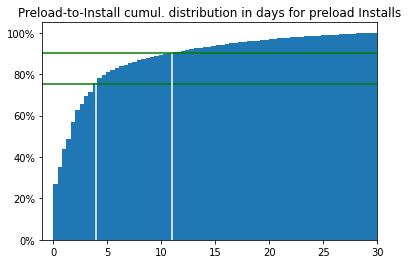

In [365]:
plt.hist(joined.loc[:, 'preload_to_install'], bins = 100, density = True, cumulative = True)
plt.gca().set_xlim(-1,30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().axvline(x=4, color = 'white')
plt.gca().axhline(y=.75, color = 'green')
plt.gca().axvline(x=11, color = 'white')
plt.gca().axhline(y=.9, color = 'green')
plt.title('Preload-to-Install cumul. distribution in days for preload Installs')

30 days for AF, kochava, branch, singular. 90 days for Adjust

Text(0.5, 1.0, 'Preload-to-install distribution in days for DSP exp. 1 installs')

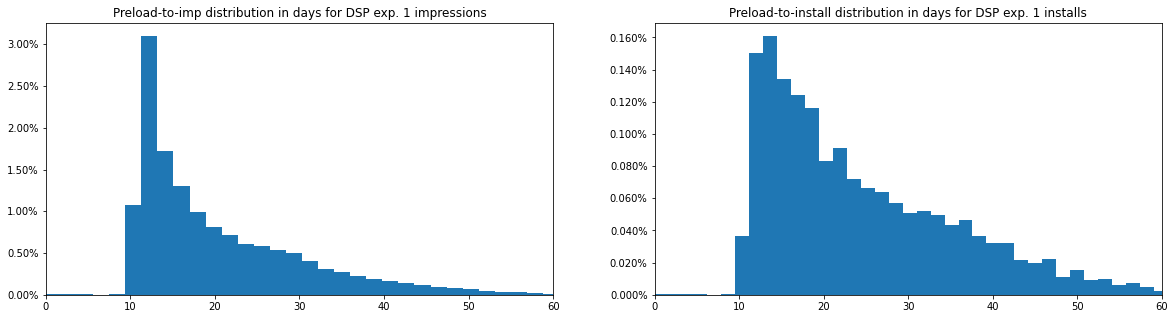

In [352]:
fig, ax = plt.subplots(1,2,figsize = (20,5))
ax[0].hist(joined['preload_to_imp_exp1'], bins = 50, weights=np.ones(len(joined['preload_to_imp_exp1'])) / len(joined['preload_to_imp_exp1']))
ax[0].set_xlim(0,60)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].set_title(f'Preload-to-imp distribution in days for DSP exp. 1 impressions')

ax[1].hist(joined['preload_to_DSP_install_exp1'], bins = 50, weights=np.ones(len(joined['preload_to_DSP_install_exp1'])) / len(joined['preload_to_DSP_install_exp1']))
ax[1].set_xlim(0,60)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].set_title(f'Preload-to-install distribution in days for DSP exp. 1 installs')

Text(0.5, 1.0, 'Preload-to-install distribution in days for DSP exp. 2 installs (post-2021-08-18)')

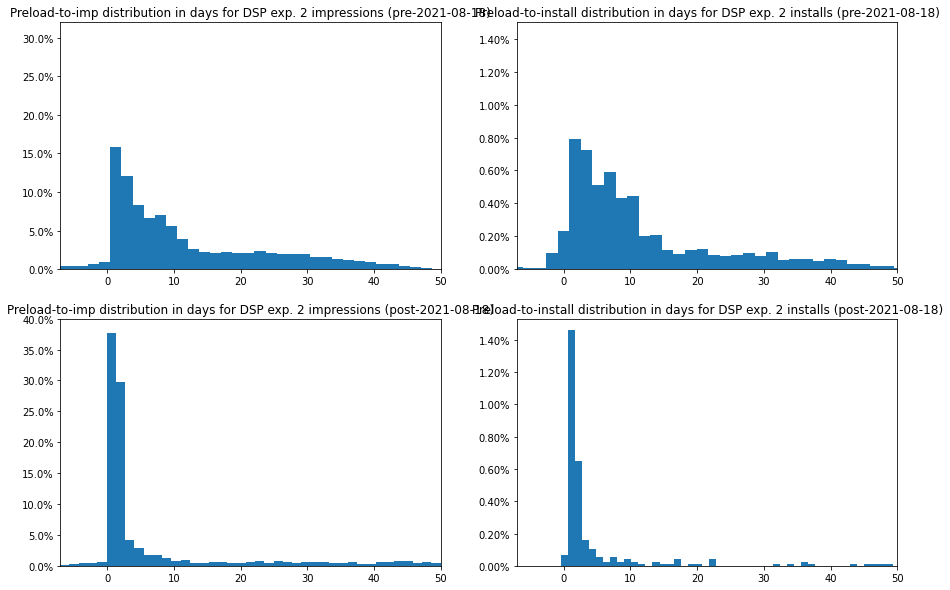

In [369]:
pre_change = joined.loc[joined.imp_ts_exp2 <= pd.to_datetime(change_dt)]
post_change = joined.loc[joined.imp_ts_exp2 >= pd.to_datetime(change_dt)]

fig, ax = plt.subplots(2,2,figsize = (15,10))
ax[0,0].hist(pre_change['preload_to_imp_exp2'], bins = 50, weights=np.ones(len(pre_change)) / len(pre_change))
ax[0,0].set_xlim(-7,50)
ax[0,0].set_ylim(0,.32)
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0,0].set_title(f'Preload-to-imp distribution in days for DSP exp. 2 impressions (pre-{change_dt})')
ax[1,0].hist(post_change['preload_to_imp_exp2'], bins = 50, weights=np.ones(len(post_change)) / len(post_change))
ax[1,0].set_xlim(-7,50)
ax[1,0].set_ylim(0,.4)
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1,0].set_title(f'Preload-to-imp distribution in days for DSP exp. 2 impressions (post-{change_dt})')
ax[0,1].hist(pre_change['preload_to_DSP_install_exp2'], bins = 50, weights=np.ones(len(pre_change)) / len(pre_change))
ax[0,1].set_xlim(-7,50)
ax[0,1].set_ylim(0,.015)
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0,1].set_title(f'Preload-to-install distribution in days for DSP exp. 2 installs (pre-{change_dt})')
ax[1,1].hist(post_change['preload_to_DSP_install_exp2'], bins = 50, weights=np.ones(len(post_change)) / len(post_change))
ax[1,1].set_xlim(-7,50)
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1,1].set_title(f'Preload-to-install distribution in days for DSP exp. 2 installs (post-{change_dt})')

Prior to the change, there are preloads and DSP impressions happening concurrently. However, they tend to happen around the same day - *why would this be the case for DSP impressions?* This also increases after the change.

Vulcan table delay is 24-48 hours - expected.

Text(0.5, 1.0, 'Preload-to-install distribution in days for installs attributed to other partners (non-organic)')

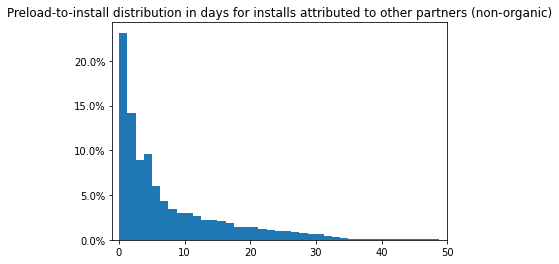

In [370]:
other_attr_install = joined[joined.preload_to_other_attr_install>0]
plt.hist(other_attr_install['preload_to_other_attr_install'], bins = 50, weights=np.ones(len(other_attr_install['preload_to_other_attr_install'])) / len(other_attr_install['preload_to_other_attr_install']))
plt.gca().set_xlim(-1,50)
# plt.gca().set_ylim(0,.25)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title(f'Preload-to-install distribution in days for installs attributed to other partners (non-organic)')

Looks like our preloads are getting attributed to other partners at a rate similar to that of getting attributed to DT.

# Adding in blacklist

*Did impressions on blacklisted devices stop?* filter below for experience 2

In [195]:
preloads_ts = df_preload[['tid','preload_ts']]
preloads_ts['preload_ts'] = preloads_ts.preload_ts.dt.tz_localize('UTC')
bl_check_df = pd.merge(bq_result[bq_result.experience_type == 2], preloads_ts, on = 'tid', how = 'left')
bl_check_df['preload_device'] = np.where(bl_check_df.preload_ts <= bl_check_df.etimestamp, True, False)
bl_check_df.groupby('preload_device')['impressions','spend','installs'].sum()

impressions   spend  installs
preload_device                               
False                  7814   175.1       103
True                 134477  3221.0      1896

In [219]:
pivot = bl_check_df.pivot_table(values = 'impressions', index = 'date', columns = 'preload_device', aggfunc = np.sum, margins = True)
pivot

preload_device  False    True     All
date                                 
2021-07-28        232    1934    2166
2021-07-29        255    2440    2695
2021-07-30        308    3245    3553
2021-07-31        337    3513    3850
2021-08-01        380    3665    4045
2021-08-02        358    3767    4125
2021-08-03        333    3917    4250
2021-08-04        305    3870    4175
2021-08-05        298    4149    4447
2021-08-06        333    4469    4802
2021-08-07        328    4951    5279
2021-08-08        343    5013    5356
2021-08-09        341    5093    5434
2021-08-10        336    6204    6540
2021-08-11        305    5631    5936
2021-08-12        314    5837    6151
2021-08-13        380    7005    7385
2021-08-14        417    7808    8225
2021-08-15        398    7997    8395
2021-08-16        370    8852    9222
2021-08-17        305    7904    8209
2021-08-18        236    7781    8017
2021-08-19         80    2196    2276
2021-08-20         64    1563    1627
2021-08-21         94    1803    1897
2021-08-22        101    1903    2004
2021-08-23         65    1416    1481
2021-08-24         49    1523    1572
2021-08-25         35    1604    1639
2021-08-26         41    1774    1815
2021-08-27         28    1732    1760
2021-08-28         34    1697    1731
2021-08-29         11    2221    2232
All              7814  134477  142291

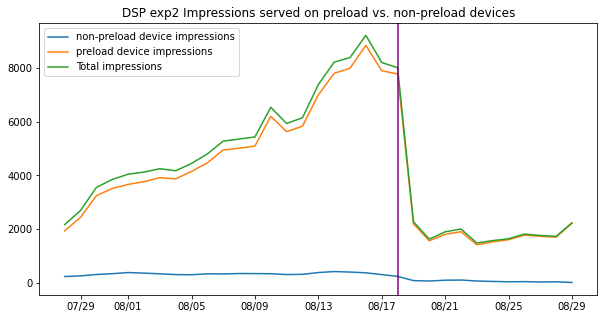

In [220]:
plt.figure(figsize = (10,5))
plt.plot(pivot[pivot.index != 'All'])
plt.title('DSP exp2 Impressions served on preload vs. non-preload devices')
plt.legend(['non-preload device impressions','preload device impressions', 'Total impressions'])
plt.gca().axvline(x=pd.to_datetime(change_dt), color = 'purple')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

(array([  687.,  2528.,  5337., 54725., 64206., 27729., 24462., 14062.,
         6477.,   369.]),
 array([-33. , -23.5, -14. ,  -4.5,   5. ,  14.5,  24. ,  33.5,  43. ,
         52.5,  62. ]),
 <BarContainer object of 10 artists>)

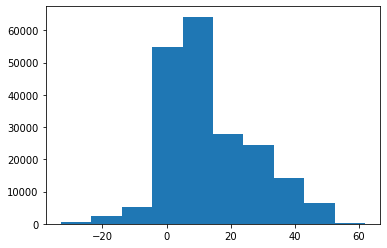

In [202]:
bl_check_df['preload_to_event'] = (bl_check_df.etimestamp - bl_check_df.preload_ts).dt.days
plt.hist(bl_check_df['preload_to_event'])

impressions on blacklisted devices didn't stop - but the blacklist was pulled on 8/25, but was updated each day starting 8/18. So the devices that still got impressions could have been blacklisted at a later date.

Did preload installs on blacklisted devices increase?

In [225]:
blacklist = pd.read_csv(f'files/{BL_filename}', header = None)
blacklist.columns = ['advertising_id']
blacklist_aaids = blacklist['advertising_id'].unique().tolist()


In [243]:
df_preload['bl_device'] = df_preload.tid.isin(blacklist_tid_list)
df_preload['preload_date'] = df_preload.preload_ts.dt.date
pivot_preload = df_preload[~df_preload.preload_ts.isna()].pivot_table(values = 'tid', index = 'preload_date', columns = 'bl_device', aggfunc = lambda x:len(x.unique()), margins = True)
pivot_preload.columns = ['non-BL_device_preloads','BL_device_preloads','total_preloads']
pivot_install = df_preload[~df_preload.install_ts.isna()].pivot_table(values = 'tid', index = 'preload_date', columns = 'bl_device', aggfunc = lambda x:len(x.unique()), margins = True)
pivot_install.columns = ['non-BL_device_installs','BL_device_installs','total_installs']

pivot = pivot_preload.join(pivot_install, how = 'left')
pivot['non-BL_device_CVR'] = 100*pivot['non-BL_device_installs']/pivot['non-BL_device_preloads']
pivot['BL_device_CVR'] = 100*pivot['BL_device_installs']/pivot['BL_device_preloads']
pivot['total_CVR'] = 100*pivot['total_installs']/pivot['total_preloads']
pivot.style.format('{:,.0f}').format({'non-BL_device_CVR':'{:,.0f}%','BL_device_CVR':'{:,.0f}%','total_CVR':'{:,.0f}%'})

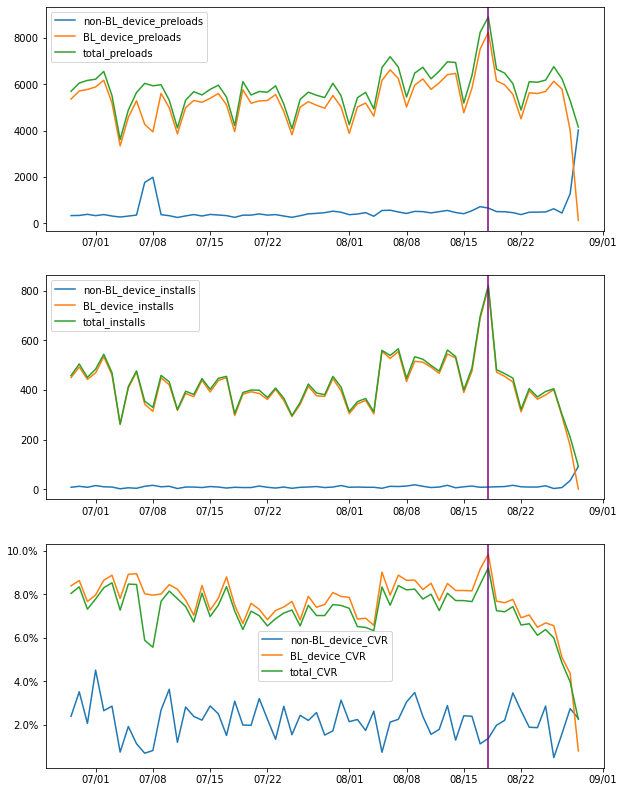

In [244]:
fig, ax = plt.subplots(3,1,figsize = (10,14))
ax[0].plot(pivot_preload.loc[(pivot_preload.index != 'All') & (pd.to_datetime(pivot_preload.index, errors = 'coerce') <= pd.to_datetime(end_dt)), pivot_preload.columns])
ax[0].legend(pivot_preload.columns)
ax[0].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].plot(pivot_install.loc[(pivot_install.index != 'All') & (pd.to_datetime(pivot_install.index, errors = 'coerce') <= pd.to_datetime(end_dt)), pivot_install.columns])
ax[1].legend(pivot_install.columns)
ax[1].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].plot(pivot.loc[(pivot.index != 'All') & (pd.to_datetime(pivot.index, errors = 'coerce') <= pd.to_datetime(end_dt)), ['non-BL_device_CVR','BL_device_CVR','total_CVR']])
ax[2].legend(pivot.columns[6:])
ax[2].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

Looks like there is no increase in preload installs on blacklisted devices after the change. In fact, strangely there is a decrease in BL device installs, and increase in non-BL device installs. This might be due to the inherent nature of counting installs from a fixed list of preloads?

In [245]:
# split preloads that weren't served DSP impressions. Did these preloads convert higher?

(array([4.000e+00, 5.000e+00, 1.100e+01, 1.000e+01, 1.900e+01, 1.900e+01,
        2.300e+01, 2.700e+01, 1.600e+01, 2.600e+01, 3.300e+01, 2.300e+01,
        5.200e+01, 4.400e+01, 6.600e+01, 6.500e+01, 5.600e+01, 7.200e+01,
        7.200e+01, 7.100e+01, 6.000e+01, 7.500e+01, 7.100e+01, 6.200e+01,
        5.800e+01, 6.900e+01, 7.000e+01, 7.100e+01, 7.000e+01, 9.300e+01,
        9.400e+01, 1.110e+02, 1.080e+02, 1.490e+02, 1.340e+02, 5.520e+02,
        6.118e+03, 4.068e+03, 2.318e+03, 1.776e+03, 1.468e+03, 1.376e+03,
        1.288e+03, 1.316e+03, 1.155e+03, 1.071e+03, 1.021e+03, 7.480e+02,
        5.260e+02, 4.010e+02, 3.930e+02, 3.880e+02, 4.070e+02, 3.830e+02,
        4.000e+02, 3.920e+02, 4.000e+02, 4.130e+02, 4.090e+02, 4.210e+02,
        4.160e+02, 3.740e+02, 3.950e+02, 3.960e+02, 3.470e+02, 3.370e+02,
        3.340e+02, 3.840e+02, 3.220e+02, 3.400e+02, 2.890e+02, 2.960e+02,
        2.860e+02, 2.380e+02, 2.650e+02, 2.120e+02, 1.920e+02, 1.850e+02,
        1.560e+02, 1.550e+02, 1.240e+0

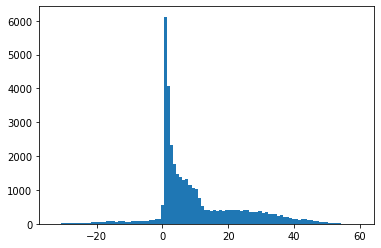

In [258]:
plt.hist(joined.preload_to_imp_exp2, bins = 100)

almost all "first impressions" per device on experience 2 are after the preload. Let's assume that if the first impression is not after the preload, then no impression is after the preload. 

In [371]:
joined['has_exp2_imp'] = np.where(
    (joined.preload_to_imp_exp2 > 2) & 
    (joined.install_ts.isna() | (joined.install_ts > joined.imp_ts_exp2))
,True, False)
joined

preload_ts          install_ts  \
tid                                                                        
7c96f33507c025310ad3d3c08a2443da 2021-07-31 14:37:51 2021-08-10 11:03:20   
ab798271f0de6f639eb06086b843862c 2021-07-01 15:53:11                 NaT   
1dee1829aaa273e7252445ddb39f3bf5 2021-07-27 14:16:43                 NaT   
ba12bef6710f87a1e29257adf1330f57 2021-07-01 12:28:42                 NaT   
d467b052d4c733af5473e682c4326ae3 2021-07-16 21:02:18                 NaT   
...                                              ...                 ...   
2c8f8305b764344f786759a3859da400 2021-08-06 14:19:50                 NaT   
3232b8401e629b56e7473c3c4c43dbd8 2021-08-22 13:15:15                 NaT   
dcc57e16f2f7f89d6a0d9a828710bb95 2021-06-30 20:58:32                 NaT   
0793150e291609b8a9b53466e4b47ff3 2021-08-13 02:08:10                 NaT   
d6f86ab2a4cc627230d8240f48224da0 2021-08-09 16:12:30 2021-08-09 16:48:26   

                                  preload_to_install  placement_id  \
tid                                                                  
7c96f33507c025310ad3d3c08a2443da            9.851030             1   
ab798271f0de6f639eb06086b843862c                 NaN             1   
1dee1829aaa273e7252445ddb39f3bf5                 NaN             1   
ba12bef6710f87a1e29257adf1330f57                 NaN             1   
d467b052d4c733af5473e682c4326ae3                 NaN             1   
...                                              ...           ...   
2c8f8305b764344f786759a3859da400                 NaN             1   
3232b8401e629b56e7473c3c4c43dbd8                 NaN             1   
dcc57e16f2f7f89d6a0d9a828710bb95                 NaN             1   
0793150e291609b8a9b53466e4b47ff3                 NaN             1   
d6f86ab2a4cc627230d8240f48224da0            0.024954             1   

                                                        advertising_id  \
tid                                                                      
7c96f33507c025310ad3d3c08a2443da  00004651-ec94-41b9-b235-8db669597a50   
ab798271f0de6f639eb06086b843862c  000071ea-3864-47f7-b67e-19423bb5fbf0   
1dee1829aaa273e7252445ddb39f3bf5  00008c40-4446-4235-a65f-9f4e57543230   
ba12bef6710f87a1e29257adf1330f57  0000a79a-0caa-4730-a326-1c34b1343840   
d467b052d4c733af5473e682c4326ae3  0000f14a-994d-4842-898d-2be13405f3c0   
...                                                                ...   
2c8f8305b764344f786759a3859da400  fffefb15-1061-4616-be43-cf01b27cedd0   
3232b8401e629b56e7473c3c4c43dbd8  ffff3ab8-5d0a-4e71-a08d-dedb47bb55c0   
dcc57e16f2f7f89d6a0d9a828710bb95  ffff54d2-f8a4-4f31-83b7-37a877d35ea0   
0793150e291609b8a9b53466e4b47ff3  ffff7c77-877c-4372-ac6b-fcad926ff1e0   
d6f86ab2a4cc627230d8240f48224da0  ffffc484-c26e-4bb4-8dbb-16e7b5c16c00   

                                         imp_ts_exp1 DSP_install_ts_exp1  \
tid                                                                        
7c96f33507c025310ad3d3c08a2443da                 NaT                 NaT   
ab798271f0de6f639eb06086b843862c                 NaT                 NaT   
1dee1829aaa273e7252445ddb39f3bf5 2021-08-13 15:51:23                 NaT   
ba12bef6710f87a1e29257adf1330f57 2021-08-01 23:35:50                 NaT   
d467b052d4c733af5473e682c4326ae3                 NaT                 NaT   
...                                              ...                 ...   
2c8f8305b764344f786759a3859da400                 NaT                 NaT   
3232b8401e629b56e7473c3c4c43dbd8                 NaT                 NaT   
dcc57e16f2f7f89d6a0d9a828710bb95                 NaT                 NaT   
0793150e291609b8a9b53466e4b47ff3                 NaT                 NaT   
d6f86ab2a4cc627230d8240f48224da0                 NaT                 NaT   

                                         imp_ts_exp2 DSP_install_ts_exp2  \
tid                                                                        
7c96f33507c025310ad3d3c08a2443da      

In [416]:
joined['preload_date'] = joined.preload_ts.dt.date
pivot = joined.pivot_table(values = ['preload_ts','install_ts'], index = 'preload_date', columns = 'has_exp2_imp', aggfunc = 'count')
pivot[('install_ts','All')] = pivot[('install_ts',False)]+pivot[('install_ts',True)]
pivot[('preload_ts','All')] = pivot[('preload_ts',False)]+pivot[('preload_ts',True)]
pivot[('CVR',False)] = 100*pivot[('install_ts',False)]/pivot[('preload_ts',False)]
pivot[('CVR',True)] = 100*pivot[('install_ts',True)]/pivot[('preload_ts',True)]
pivot[('CVR','All')] = 100*pivot[('install_ts','All')]/pivot[('preload_ts','All')]
pivot.index = pd.to_datetime(pivot.index)
pivot


install_ts      preload_ts        install_ts preload_ts  \
has_exp2_imp      False True      False   True        All        All   
preload_date                                                           
2021-06-28        458.0  0.0     5410.0  289.0      458.0     5699.0   
2021-06-29        505.0  0.0     5716.0  337.0      505.0     6053.0   
2021-06-30        451.0  0.0     5780.0  387.0      451.0     6167.0   
2021-07-01        484.0  0.0     5808.0  410.0      484.0     6218.0   
2021-07-02        544.0  0.0     6092.0  462.0      544.0     6554.0   
...                 ...  ...        ...    ...        ...        ...   
2021-08-25        392.0  2.0     6142.0   38.0      394.0     6180.0   
2021-08-26        405.0  0.0     6700.0   62.0      405.0     6762.0   
2021-08-27        302.0  0.0     6157.0   82.0      302.0     6239.0   
2021-08-28        210.0  NaN     5298.0    NaN        NaN        NaN   
2021-08-29         93.0  NaN     4155.0    NaN        NaN        NaN   

                   CVR                      
has_exp2_imp     False      True       All  
preload_date                                
2021-06-28    8.465804  0.000000  8.036498  
2021-06-29    8.834850  0.000000  8.342970  
2021-06-30    7.802768  0.000000  7.313118  
2021-07-01    8.333333  0.000000  7.783853  
2021-07-02    8.929744  0.000000  8.300275  
...                ...       ...       ...  
2021-08-25    6.382286  5.263158  6.375405  
2021-08-26    6.044776  0.000000  5.989352  
2021-08-27    4.904986  0.000000  4.840519  
2021-08-28    3.963760       NaN       NaN  
2021-08-29    2.238267       NaN       NaN  

[63 rows x 9 columns]

In [417]:
pivot.columns

MultiIndex([('install_ts', False),
            ('install_ts',  True),
            ('preload_ts', False),
            ('preload_ts',  True),
            ('install_ts', 'All'),
            ('preload_ts', 'All'),
            (       'CVR', False),
            (       'CVR',  True),
            (       'CVR', 'All')],
           names=[None, 'has_exp2_imp'])

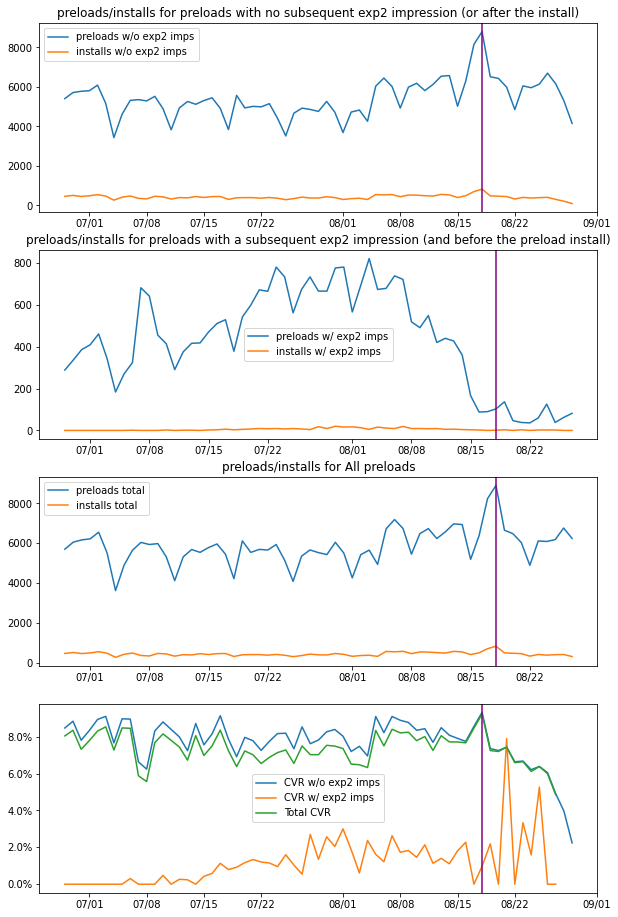

In [378]:
fig, ax = plt.subplots(4,1,figsize = (10,16))
ax[0].plot(pivot[[('preload_ts',False),('install_ts',False)]])
ax[0].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[0].legend(['preloads w/o exp2 imps','installs w/o exp2 imps'])
ax[0].set_title('preloads/installs for preloads with no subsequent exp2 impression (or after the install)')
ax[1].plot(pivot[[('preload_ts',True),('install_ts',True)]])
ax[1].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].legend(['preloads w/ exp2 imps','installs w/ exp2 imps'])
ax[1].set_title('preloads/installs for preloads with a subsequent exp2 impression (and before the preload install)')
ax[2].plot(pivot[[('preload_ts','All'),('install_ts','All')]])
ax[2].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].legend(['preloads total','installs total'])
ax[2].set_title('preloads/installs for All preloads')
ax[3].plot(pivot['CVR'])
ax[3].axvline(x=pd.to_datetime(change_dt), color = 'purple')
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[3].legend(['CVR w/o exp2 imps','CVR w/ exp2 imps','Total CVR'])
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))